# DeepXDE - Bernard Cavity

In this notebook i'll be implementing the bernard cavity case. I'll be following the paper Hashemi+2024 and adding some twists to make it work better as i go.

In [16]:
import deepxde as dde
import torch
import numpy as np

import matplotlib.pyplot as plt


dde.config.set_default_float("float64")
torch.set_default_device('cuda:1') 

Set the default float type to float64


In [17]:
rho = 1
mu = 0.001
alpha = 0.005
D = 0.1
L = D
beta = 1.0
g = 9.81

T0 = 0
T_bottom = 1

S0 = (T0 - T0)/(T_bottom - T0)
S_bottom = (T_bottom - T0)/(T_bottom - T0)


assert T_bottom > T0, "For a Benard cell the bottom temperature should be higher than the rest"

Ra = g*beta*(T_bottom-T0)*D**3*rho/(alpha*mu)
Pr = mu/(rho*alpha)
Gr = g*beta*(T_bottom - T0)*L**3*rho**2/mu**2
print(f"{Ra = }, {Pr = }, {Gr = }")

Ra = 1962.0000000000005, Pr = 0.2, Gr = 9810.000000000004


In [18]:
# Define geometry

## Let's go with a square for this case
geom = dde.geometry.Rectangle(xmin=(0, 0), xmax=(L/L, D/D))

# Define boundaries and boundary conditions
def boundary_top(X,on_boundary):
    on = np.logical_and(dde.utils.isclose(X[1], D/D),on_boundary)
    return on


def boundary_bottom(X,on_boundary):
    on = np.logical_and(dde.utils.isclose(X[1], 0),on_boundary)
    return on

def boundary_sides(X,on_boundary):
    on = ~boundary_bottom(X, on_boundary) and ~boundary_top(X, on_boundary) and on_boundary
    return on

def boundary_walls(X,on_boundary):
    return on_boundary


## Here we will have 2 dirichlet conditions on the speed components and one in the pressure 

bc_wall_u = dde.DirichletBC(geom, lambda x: 0, boundary_walls, component=0)
bc_wall_v = dde.DirichletBC(geom, lambda x: 0, boundary_walls, component=1)

bc_top_T    = dde.DirichletBC(geom, lambda x: S0      , boundary_top, component=3)
bc_bottom_T = dde.DirichletBC(geom, lambda x: S_bottom, boundary_bottom, component=3)
bc_sides_T  = dde.NeumannBC(geom,   lambda x: 0       , boundary_sides, component=3)


# # Define pde
# def pde(X,Y):
#     """Boussinesq approximated NS equations"""
    
#     du_x = dde.grad.jacobian(Y, X, i=0, j=0)
#     du_y = dde.grad.jacobian(Y, X, i=0, j=1)
#     dv_x = dde.grad.jacobian(Y, X, i=1, j=0)
#     dv_y = dde.grad.jacobian(Y, X, i=1, j=1)
#     dp_x = dde.grad.jacobian(Y, X, i=2, j=0)
#     dp_y = dde.grad.jacobian(Y, X, i=2, j=1)
    
#     du_xx = dde.grad.hessian(Y, X, component=0, i=0, j=0)
#     du_yy = dde.grad.hessian(Y, X, component=0, i=1, j=1)
#     dv_xx = dde.grad.hessian(Y, X, component=1, i=0, j=0)
#     dv_yy = dde.grad.hessian(Y, X, component=1, i=1, j=1)
    
#     dT_x = dde.grad.jacobian(Y, X, i=3, j=0)
#     dT_y = dde.grad.jacobian(Y, X, i=3, j=1)
    
#     dT_xx = dde.grad.hessian(Y, X, component=3, i=0, j=0)
#     dT_yy = dde.grad.hessian(Y, X, component=3, i=1, j=1)

#     pde_cont   = du_x + dv_y
    
#     pde_u      = Y[:,0:1]*du_x +  Y[:,1:2]*du_y + 1/rho * dp_x - (mu/rho) * (du_xx+ du_yy)
#     pde_v      = Y[:,0:1]*dv_x +  Y[:,1:2]*dv_y + 1/rho * dp_y - (mu/rho) * (dv_xx+ dv_yy) + g*(1 - beta*(Y[:, 3:] - T0))
#     pde_energy = Y[:,0:1]*dT_x +  Y[:,1:2]*dT_y - alpha * (dT_xx + dT_yy)

    
#     return [pde_u, pde_v, pde_cont, pde_energy]


def pde_nondimensional(X,Y):
    """Nondimensional Boussinesq approximated NS equations"""
    
    du_x = dde.grad.jacobian(Y, X, i=0, j=0)
    du_y = dde.grad.jacobian(Y, X, i=0, j=1)
    dv_x = dde.grad.jacobian(Y, X, i=1, j=0)
    dv_y = dde.grad.jacobian(Y, X, i=1, j=1)
    dp_x = dde.grad.jacobian(Y, X, i=2, j=0)
    dp_y = dde.grad.jacobian(Y, X, i=2, j=1)
    
    du_xx = dde.grad.hessian(Y, X, component=0, i=0, j=0)
    du_yy = dde.grad.hessian(Y, X, component=0, i=1, j=1)
    dv_xx = dde.grad.hessian(Y, X, component=1, i=0, j=0)
    dv_yy = dde.grad.hessian(Y, X, component=1, i=1, j=1)
    
    dT_x = dde.grad.jacobian(Y, X, i=3, j=0)
    dT_y = dde.grad.jacobian(Y, X, i=3, j=1)
    
    dT_xx = dde.grad.hessian(Y, X, component=3, i=0, j=0)
    dT_yy = dde.grad.hessian(Y, X, component=3, i=1, j=1)

    pde_cont   = du_x + dv_y
    pde_u      = Y[:,0:1]*du_x +  Y[:,1:2]*du_y + dp_x - (Pr/Ra)**0.5*(du_xx+ du_yy)
    pde_v      = Y[:,0:1]*dv_x +  Y[:,1:2]*dv_y + dp_y - (Pr/Ra)**0.5*(dv_xx+ dv_yy) - Y[:, 3:]
    pde_energy = Y[:,0:1]*dT_x +  Y[:,1:2]*dT_y - (dT_xx + dT_yy)/(Pr*Ra)**0.5

    
    return [pde_u, pde_v, pde_cont, pde_energy]

def non_dimensionalise_input(X):
    return X/D

def transform(X, Y):
    """Ansatz to make the spped exactly zero on the boundaries"""
    noslip_ansatz_factor = X[:, 0:1] * (L/L - X[:, 0:1]) * X[:, 1:2] * (D/D - X[:, 1:2])
    temperature_ansatz = X[:, 1:2]/D/D*(S0 + (D/D - X[:, 1:2])) + S_bottom * (D/D - X[:, 1:2])/D/D

    return torch.hstack(
        (
            noslip_ansatz_factor*Y[:, 0:2],  
            Y[:, 2:3], # 1.0 + (X[:, 0:1]**2 + X[:, 1:2]**2)**0.5*
            temperature_ansatz +  X[:, 1:2] * (D - X[:, 1:2])*Y[:, 3:]
        )
    )


# def dimensionalise_output(Y):
#     Y[:, 0] = Y[:, 0]

# Define model

net = dde.maps.FNN([2,] + [512]*6 + [4,], "silu", "Glorot uniform")

HARD_NOSLIP = True

if HARD_NOSLIP:
    bcs = [bc_sides_T]
    net.apply_output_transform(transform)
else:
    bcs = [bc_wall_u, bc_wall_v, bc_top_T, bc_bottom_T, bc_sides_T]

    

data = dde.data.PDE(
    geom,
    pde_nondimensional,
    bcs,
    num_domain=1024,
    num_boundary=256,
    num_test=100
)

model = dde.Model(data, net)

In [19]:
class ReferencePointResampler(dde.callbacks.PDEPointResampler):
    def __init__(self, period, ref_point, **kwargs):
        super().__init__(period, bc_points=True, **kwargs)
        self.ref_point = ref_point

    
    def on_train_begin(self):
        """Add the desired reference point in the beginning of the trainining"""
        super().on_train_begin()
        bc_points = self.model.data.train_x_bc
        self.model.data.train_x_bc = np.vstack([bc_points, self.ref_point])
        

    def on_epoch_end(self):
        """
        Modification of parent method that add the reference point 
        after each resample if boundary points are being resampled.
        """

        self.epochs_since_last_resample = self.period

        act = self.epochs_since_last_resample == self.period
        
        super().on_epoch_end()
        
        # Append the reference point to BC points
        if self.bc_points and act:
            bc_points = self.model.data.train_x_bc
            self.model.data.train_x_bc = np.vstack([bc_points, self.ref_point])

In [20]:
resampler = ReferencePointResampler(period=100, ref_point=np.array([0, 0]))

checkpointer = dde.callbacks.ModelCheckpoint(
    filepath="model.ckpt",  # prefix and path for saved model files
    verbose=1,                           # print saving messages
    save_better_only=True,              # save every period or only if improved
    period=5_000,                       # save every epoch; set to e.g. 10 to save every 10 epochs
    monitor="train loss"                # metric to monitor, "train loss" or "test loss"
)

In [ ]:
# Train model

w1, w2 = 10, 5

loss_weights = [w1, w2, (w1*w2)**0.5, 1, 1]

#1st stage - ADAM optimizer
adam = torch.optim.Adam(net.parameters(), lr=0.001, betas=[0.9, 0.999])

model.compile(optimizer=adam, loss_weights=loss_weights)
losshistory_1, train_state_1 = model.train(iterations=97_000, callbacks=[resampler, checkpointer])

# 2nd stage - L-BFGS optimizer 
model.compile("L-BFGS", loss_weights=loss_weights)
dde.optimizers.config.set_LBFGS_options(ftol=1e-12, gtol=1e-12)
losshistory_2, train_state_2 = model.train(iterations=3_000, callbacks=[resampler, checkpointer])

Compiling model...
'compile' took 0.000100 s

Training model...

0         [6.56e-05, 2.65e+04, 4.24e-07, 1.02e+02, 9.15e-11]    [6.56e-05, 2.68e+04, 3.28e-07, 1.02e+02, 9.15e-11]    []  


In [ ]:
# model.restore("path/to/model.ckpt-xxx", verbose=1)

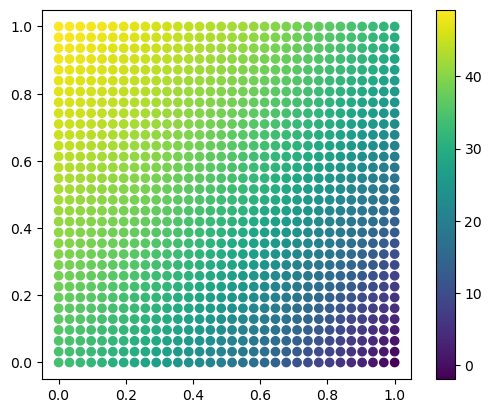

In [9]:
samples = geom.uniform_points(1000)
res = model.predict(samples) 

x, y = samples.T
u, v, p, T = res.T

plt.scatter(x, y, c=p)
plt.colorbar()

plt.gca().set_aspect("equal")

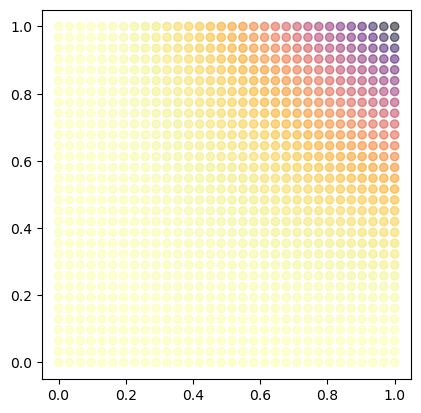

In [10]:

V = np.sqrt(v**2 + u**2)
plt.scatter(x, y, c=v, alpha=0.5, cmap="inferno")

plt.gca().set_aspect("equal")

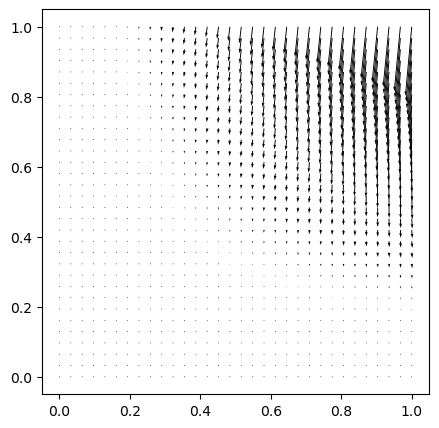

In [11]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.quiver(x, y, u, v)
# plt.gca().set_aspect("equal")

In [ ]:
samples = geom.random_boundary_points(1000)
res = model.predict(samples)

x, y = samples.T
u, v, p, T = res.T

V = np.sqrt(v**2 + u**2)
plt.scatter(x, y, c=v, alpha=0.8)

plt.colorbar()
plt.gca().set_aspect("equal")

In [ ]:
samples = geom.random_boundary_points(1000)
res = model.predict(samples)

x, y = samples.T
u, v, p, T = res.T

plt.scatter(x, y, c=p, alpha=0.8)

plt.colorbar()

plt.gca().set_aspect("equal")

In [ ]:
du_x = dde.grad.jacobian(Y, X, i=0, j=0)
du_y = dde.grad.jacobian(Y, X, i=0, j=1)